### Import Libraries and Data :

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [49]:
df = pd.read_csv('loan-train.csv')

In [4]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### EDA :

In [6]:
df.shape

(614, 13)

In [7]:
df.dtypes.value_counts()

object     8
float64    4
int64      1
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [9]:
df.isna().sum() / df.shape[0] * 100

Loan_ID              0.000000
Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

In [10]:
df.describe(include = 'all')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,614,601,611,599,614,582,614.000000,614.000000,592.000000,600.00000,564.000000,614,614
unique,614,2,2,4,2,2,NaN,NaN,NaN,NaN,NaN,3,2
top,LP001345,Male,Yes,0,Graduate,No,NaN,NaN,NaN,NaN,NaN,Semiurban,Y
freq,1,489,398,345,480,500,NaN,NaN,NaN,NaN,NaN,233,422
mean,NaN,NaN,NaN,NaN,NaN,NaN,5403.459283,1621.245798,146.412162,342.00000,0.842199,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,6109.041673,2926.248369,85.587325,65.12041,0.364878,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,150.000000,0.000000,9.000000,12.00000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,2877.500000,0.000000,100.000000,360.00000,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,3812.500000,1188.500000,128.000000,360.00000,1.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,5795.000000,2297.250000,168.000000,360.00000,1.000000,NaN,NaN


In [11]:
df.Loan_Status.value_counts() / df.shape[0] * 100

Y    68.729642
N    31.270358
Name: Loan_Status, dtype: float64

In [12]:
df.duplicated().sum()

0

<AxesSubplot:xlabel='Loan_Status'>

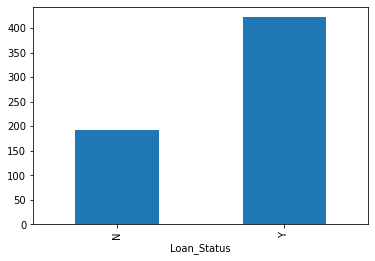

In [17]:
df.groupby('Loan_Status')['Loan_ID'].count().plot(kind = 'bar')

The target is not balanced, so it's better to use F1 score as metric.


Let's see now how are the distributions of our numerical features :

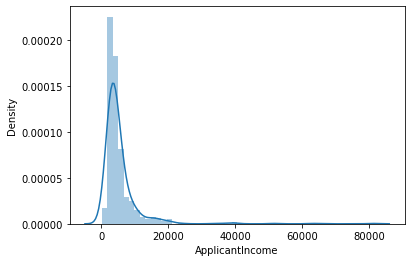

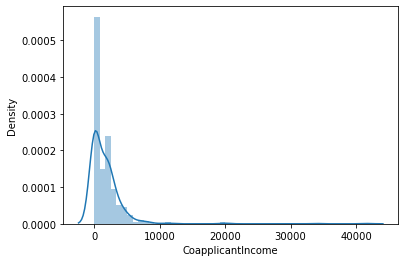

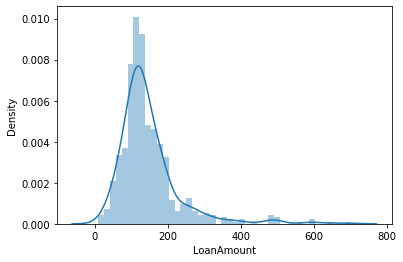

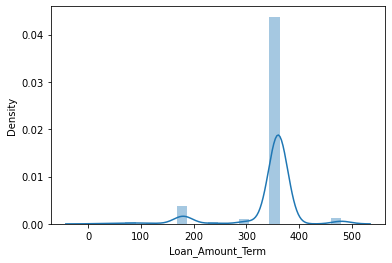

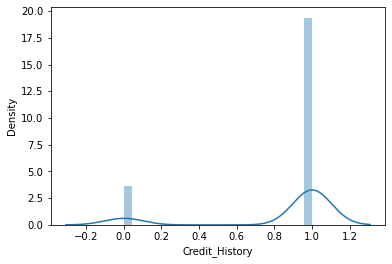

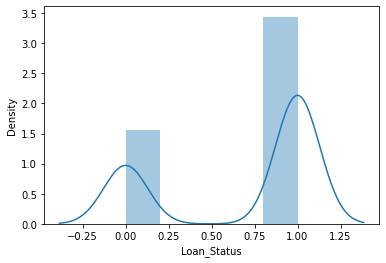

In [100]:
for col in df.select_dtypes(exclude = 'O').columns :
    plt.figure()
    sns.distplot(df[col])

Loan Amount Term and Credit History columns seems to be categorical.

Also the ApplicantIncome and LoanAmount columns are skewed so let's apply on it the log function.

In [50]:
df['ApplicantIncome'] = np.log1p(df['ApplicantIncome'])
df['LoanAmount'] = np.log1p(df['LoanAmount'])

Let's check now the distrbutions again

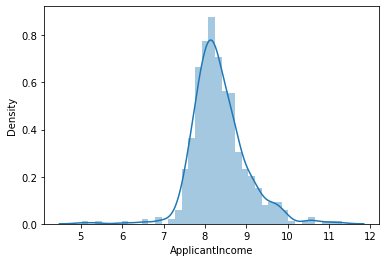

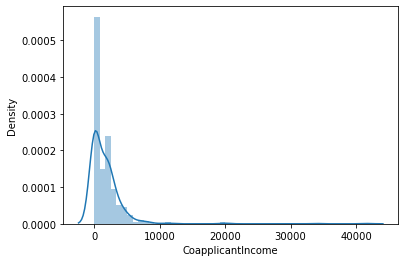

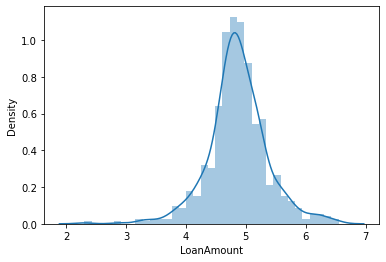

In [23]:
for col in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'] :
    plt.figure()
    sns.distplot(df[col])

It's time to see the relationship between some features and the target variable.

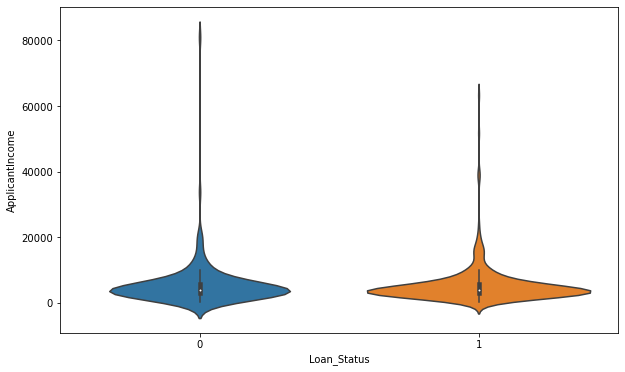

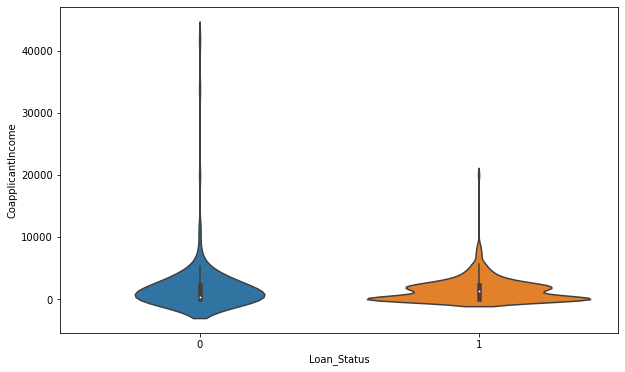

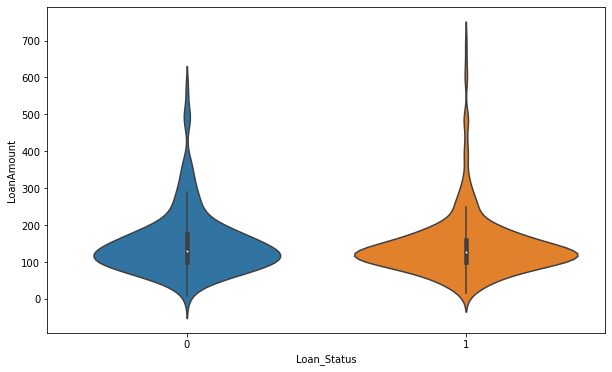

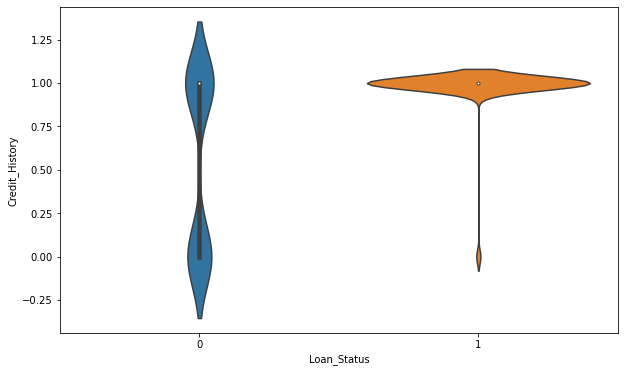

In [99]:
for col in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History'] :
    plt.figure(figsize=(10,6))
    sns.violinplot(y=col, x="Loan_Status", data=df)

The Credit History effect the Loan Status. 

Let's convert our Loan_Amount_Term column into categories, thus we can use it in our analysis.

In [56]:
df.Loan_Amount_Term.value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [51]:
# we convert the column to short, med or long term loan.
def LoanTerm(elt) :
    if elt <= 200 :
        return 'short term'
    elif 200<elt<=300 :
        return 'med term'
    else :
        return 'long term'
    
df['Loan_Amount_Term_cat'] = df.Loan_Amount_Term.apply(LoanTerm)

In [240]:
df.Loan_Amount_Term_cat.value_counts()

long term     541
short term     56
med term       17
Name: Loan_Amount_Term_cat, dtype: int64

In [76]:
# we check now the unique values of our categorical features :
for col in ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Amount_Term', 'Loan_Status'] :
    print(f'{col :-<40} {df[col].unique()}')

Gender---------------------------------- ['Male' 'Female' nan]
Married--------------------------------- ['No' 'Yes' nan]
Dependents------------------------------ ['0' '1' '2' '3+' nan]
Education------------------------------- ['Graduate' 'Not Graduate']
Self_Employed--------------------------- ['No' 'Yes' nan]
Property_Area--------------------------- ['Urban' 'Rural' 'Semiurban']
Loan_Amount_Term------------------------ ['long term' 'short term' 'med term']
Loan_Status----------------------------- ['Y' 'N']


Loan_Amount_Term and Dependents are ordered columns, so later we can use ordinal encoder on it, and one hot encoder for the other ones.

In [52]:
# we convert the taret into 1 and 0 values to check the correlation with the other numerical features
df.Loan_Status = df.Loan_Status.map({'Y':1, 'N':0})

<AxesSubplot:>

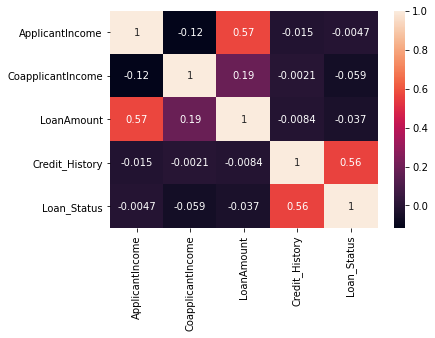

In [79]:
sns.heatmap(df.corr(), annot = True)

As we concluded before, the strong relationship is with the Credit History column

Let's separate our data based on the loan status, then do some analysis by comparing the two datasets.

In [45]:
loanY = df[df.Loan_Status == 1]
loanN = df[df.Loan_Status == 0]

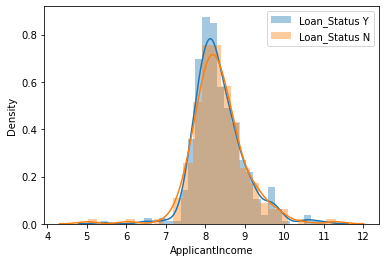

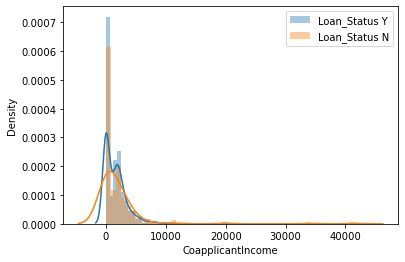

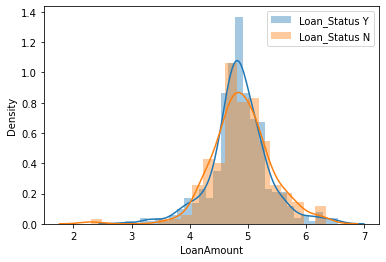

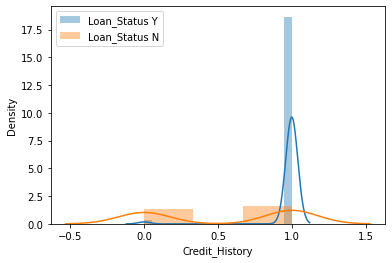

In [47]:
for col in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History'] :
    plt.figure()
    sns.distplot(loanY[col], label='Loan_Status Y')
    sns.distplot(loanN[col], label='Loan_Status N')
    plt.legend()

People who took a loan before, they are more likely to get a second one, also no big differences between the two parts for the other columns.

Let's check now the categorical columns :

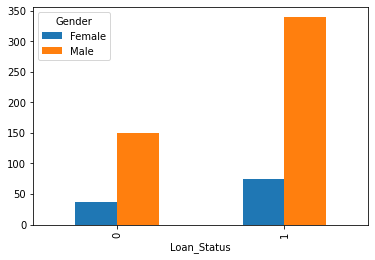

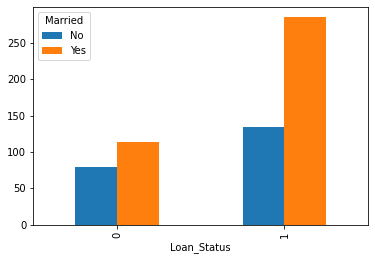

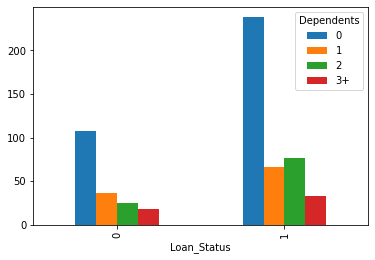

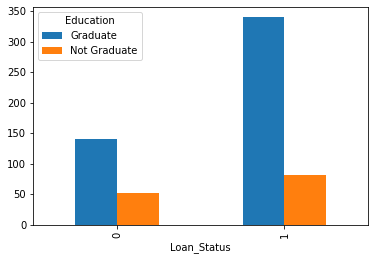

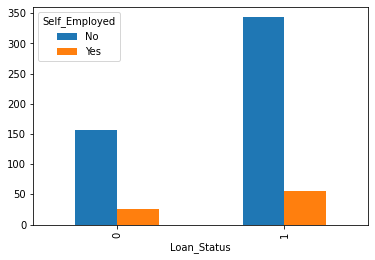

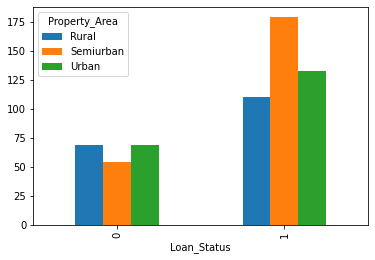

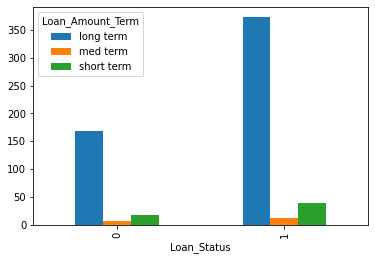

In [87]:
for col in ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Amount_Term'] :
    pd.crosstab(df['Loan_Status'], df[col]).plot.bar()

People whith no dependencies or with two ines are more likely to get their loan, also people in semiurban have same tendencies.

If you are married or graduate, then the chance you got the loan is high.

## Pre-processing :

In [8]:
from sklearn.model_selection import train_test_split

In [53]:
# we drop these two insignificant columns
df.drop(['Loan_Amount_Term', 'Loan_ID'], axis = 1, inplace = True)

In [10]:
# train-test split of the data
x = df.drop('Loan_Status', axis = 1)
y = df.Loan_Status

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [30]:
df.isna().sum()

Loan_ID                  0
Gender                  13
Married                  3
Dependents              15
Education                0
Self_Employed           32
ApplicantIncome          0
CoapplicantIncome        0
LoanAmount              22
Credit_History          50
Property_Area            0
Loan_Status              0
Loan_Amount_Term_cat     0
dtype: int64

In [11]:
def impute(data) :
    data.Gender = data.Gender.fillna(x_train.Gender.mode()[0])
    data.Married = data.Married.fillna(x_train.Married.mode()[0])
    data.Dependents = data.Dependents.fillna(x_train.Dependents.mode()[0])
    data.Self_Employed = data.Self_Employed.fillna(x_train.Self_Employed.mode()[0])
    data.LoanAmount = data.LoanAmount.fillna(x_train.LoanAmount.mean())
    data.Credit_History = data.Credit_History.fillna(1)
    

impute(x_train)
impute(x_test)

In [115]:
x_train.isna().sum()

Loan_ID                 0
Gender                  0
Married                 0
Dependents              0
Education               0
Self_Employed           0
ApplicantIncome         0
CoapplicantIncome       0
LoanAmount              0
Credit_History          0
Property_Area           0
Loan_Amount_Term_cat    0
dtype: int64

In [12]:
# data scaling
def scaling(data) :
    features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
    ss = StandardScaler()
    x_train.loc[:, features] = ss.fit_transform(x_train.loc[:, features])
    data.loc[:, features] = ss.transform(data.loc[:, features])
    
scaling(x_test)

In [13]:
# data encoding
def encoding(data) :
    # for noram columns with no order in values
    data = pd.get_dummies(data, columns = ['Gender', 'Married', 'Education',
                                           'Self_Employed', 'Property_Area'], drop_first=True) 
    
    # for ordered columns
    data.Dependents = data.Dependents.map({'0':0, '1':1, '2':2, '3+':3})
    data.Loan_Amount_Term_cat = data.Loan_Amount_Term_cat.map({'short term':0, 'med term':1, 'long term':2})
    return data
    
x_train = encoding(x_train)
x_test = encoding(x_test)

In [24]:
x_train

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Credit_History,Loan_Amount_Term_cat,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban
90,0,-0.555433,0.493485,0.032544,1.0,2,1,1,0,0,1,0
533,1,1.455873,-0.547973,0.832169,1.0,2,1,0,0,0,1,0
452,0,-0.120810,0.074388,0.287834,0.0,2,1,1,0,0,0,0
355,0,-0.173192,-0.547973,-0.208357,1.0,0,0,0,0,0,0,1
266,2,0.144250,-0.049869,0.301104,1.0,2,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
277,0,-0.483390,-0.081113,-0.942724,1.0,2,1,1,0,0,0,1
9,1,1.655052,3.390891,1.979935,1.0,2,1,1,0,0,1,0
359,3,0.284316,0.589370,0.872312,1.0,2,1,1,0,0,1,0
192,0,0.517619,-0.547973,0.429164,1.0,2,1,1,1,0,0,1


### Modeling and Evaluation :

In [25]:
model = DecisionTreeClassifier(random_state=0)
model.fit(x_train, y_train)
pred = model.predict(x_test)

print(f1_score(pred, y_test))
print(classification_report(pred, y_test)) # diminish

0.8070175438596491
              precision    recall  f1-score   support

           0       0.64      0.50      0.56        42
           1       0.77      0.85      0.81        81

    accuracy                           0.73       123
   macro avg       0.70      0.68      0.68       123
weighted avg       0.72      0.73      0.72       123



In [28]:
NBClassifier=GaussianNB()
NBClassifier.fit(x_train,y_train)
predNB = NBClassifier.predict(x_test)

print(f1_score(predNB, y_test))
print(classification_report(predNB, y_test))

0.8923076923076922
              precision    recall  f1-score   support

           0       0.45      0.83      0.59        18
           1       0.97      0.83      0.89       105

    accuracy                           0.83       123
   macro avg       0.71      0.83      0.74       123
weighted avg       0.89      0.83      0.85       123



In [54]:
loj = LogisticRegression(solver = "liblinear")
loj.fit(x_train,y_train)
predLR = loj.predict(x_test)

print(f1_score(predLR, y_test))
print(classification_report(predLR, y_test))

0.8979591836734695
              precision    recall  f1-score   support

           0       0.45      0.88      0.60        17
           1       0.98      0.83      0.90       106

    accuracy                           0.84       123
   macro avg       0.72      0.86      0.75       123
weighted avg       0.91      0.84      0.86       123



In [31]:
param_grid_lr = {
    'max_iter': [100, 200, 500],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  
    'penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'C': [100, 10, 1.0, 0.1, 0.01]
    #'class_weight': ['balanced']                                    
}

In [32]:
logModel_grid = GridSearchCV(estimator=LogisticRegression(), param_grid=param_grid_lr, verbose=1, cv=10, n_jobs=-1)

In [33]:
logModel_grid.fit(x_train, y_train)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [100, 10, 1.0, 0.1, 0.01],
                         'max_iter': [100, 200, 500],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=1)

In [55]:
predGr = logModel_grid.predict(x_test)

print(f1_score(predGr, y_test))
print(classification_report(predGr, y_test))

0.8979591836734695
              precision    recall  f1-score   support

           0       0.45      0.88      0.60        17
           1       0.98      0.83      0.90       106

    accuracy                           0.84       123
   macro avg       0.72      0.86      0.75       123
weighted avg       0.91      0.84      0.86       123



No improvment.

The best score we got is for Logistic Regression, which is F1-score = 0.89.